# Exercise #4: Model Selection in Networks Using a Bayesian Approach

## Overview

In this exercise, we aim to understand how real-world networks form by investigating the mechanisms behind edge formation. Often, in empirical networks, we are interested in identifying whether nodes connect based on shared characteristics (homophily) or popularity (preferential attachment). 

### Key Concepts:
- **Homophily**: The tendency for similar individuals to connect more frequently. This is a common pattern in social networks [McPherson et al. 2001](https://www.annualreviews.org/content/journals/10.1146/annurev.soc.27.1.415)
- **Preferential Attachment**: The phenomenon where popular nodes (those with many connections) attract even more connections, reinforcing their popularity. This mechanism is tied to the *Matthew Effect* [Merton, 1968](https://www.science.org/doi/abs/10.1126/science.159.3810.56) and the *Barabási-Albert model* [Barabasi and Albert](https://www.science.org/doi/full/10.1126/science.286.5439.509).

There are multiple approaches to investigating these patterns, such as fitting data into generative models or using **Multiple Regression Quadratic Assignment Procedure (MRQAP)**, an extension for covariate matrices [Dekker et al. 2007](https://link.springer.com/article/10.1007/S11336-007-9016-1). However, this exercise will cover a different approach using **Bayesian inference**.

We will use **JANUS**, a model published by [Espín-Noboa et al. (2017)](https://link.springer.com/article/10.1007/s41109-017-0036-1), based on **HypTrails** [Singer et al. 2017](https://dl.acm.org/doi/abs/10.1145/3054950). This approach uses prior beliefs to calculate marginal likelihoods (evidence) for different hypotheses and compares them to determine which hypothesis best explains the connections observed in the network.

## Task

1. **Generate a Synthetic Network**: Create a synthetic network of your choice (directed or undirected).
2. **Set Hypotheses**: Use the `netin.algorithms.janus.JanusModelFitting` method to test multiple hypotheses about how the network formed.
   - **Baseline Hypotheses**: Random connections, self-loops, and data-based connections.
   - **Edge Formation Mechanisms**: Include hypotheses based on **homophily**, **preferential attachment**, or a combination of both. *Only hypotheses about undirected networks are supported so far.*
3. **Apply Bayesian Inference**: Use JANUS to compute the **marginal likelihoods** for each hypothesis.
4. **Compare Hypotheses**: Analyze the relative plausibility of each hypothesis based on the computed evidence.
5. **Store the Evidence scores**: Save to a file all the evidence scores for all your hypotheses.

### Instructions

1. Generate a synthetic network with customizable parameters (directed/undirected, size, etc.).
2. Define multiple hypotheses using JANUS, including random baselines and more sophisticated mechanisms like homophily and preferential attachment.
3. Use Bayesian inference to compare these hypotheses by calculating the marginal likelihood for each one.
4. Visualize the results to see which hypothesis best explains the formation of the synthetic network.

### Expected Outcome

By the end of this exercise, you will be able to apply a **Bayesian approach** to model selection in networks, testing multiple hypotheses about edge formation and determining which one best explains the observed patterns. This process will enhance your understanding of how to infer the underlying mechanisms of network formation using **evidence-based** comparison methods.

### Disclaimer

The implementation of Janus is in testing mode. If you encounter any bug or incosistency please report it on our [GitHub repository](https://github.com/CSHVienna/NetworkInequalities/issues).



___

In [1]:
# ### If running this on Google Colab, run the following lines:
# import os
# !pip install netin==2.0.0a1
# !pip install networkx==3.2.1
# !mkdir plots
# !mkdir results
# os.kill(os.getpid(), 9)

In [2]:
## Undirected Network models
from netin.models import BarabasiAlbertModel
from netin.models import PAModel
from netin.models import HomophilyModel
from netin.models import PAHModel
from netin.models import PATCHModel
from netin.models import CompoundLFM

In [3]:
## Directed Network models
from netin.models import DPAModel
from netin.models import DHModel
from netin.models import DPAHModel

In [4]:
## Janus: A Bayesian approach for hypothesis testing on edge formation
from netin.algorithms.janus import JanusModelFitting

In [5]:
## Utils
from netin.utils import io

## Constants

In [6]:
PLOTS = 'plots/'        # where to store the plots
OUTPUT_DIR = 'results/' # where to store the evidence values
io.validate_dir(PLOTS)
io.validate_dir(OUTPUT_DIR)

True

## Task 1. Generate a Synthetic (Undirected or Directed) Graph
This graph will serve as your "empirical" input data.

In [7]:
# Network properties
N = 2000
m = 2
f_m = 0.3
h_m = 0.9
h_M = 0.3
seed = 9876

In [8]:
m_graph = PAHModel(N=N, m=2, f_m=f_m, h_m=h_m, h_M=h_M, seed=seed)
m_graph = m_graph.simulate()

## Task 2. Generate hypotheses and compute their marginal likelihood
Hint:  
```python
JanusModelFitting(graph: Graph,
is_global: bool = True, 
k_max: int = 10, 
k_log_scale: bool = True, 
**attr)```

In [9]:
# Janus' parameters
is_global = False
k_max = 10
k_log_scale = False
verbose = False

In [10]:
j = JanusModelFitting(graph=m_graph, 
                      is_global=is_global, 
                      k_max=k_max, 
                      k_log_scale=k_log_scale, 
                      verbose=verbose)

### Default hypothesis
Hint:
```python
h = j.get_uniform_hypothesis() -> Hypothesis
e = j.generate_evidences(h: Hypothesis)

#### Uniform

In [11]:
# Uniform (all nodes are equally likely to be connected to each other)
h = j.get_uniform_hypothesis()
e = j.generate_evidences(h)
j.add_evidences(h.name, e)
del(e)
del(h)

/home/espinl/.conda/envs/py39snmaecmlpkdd24/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


#### Self-loop

In [12]:
# Self-loop hypothesis (only diagonal)
h = j.get_self_loop_hypothesis()
e = j.generate_evidences(h)
j.add_evidences(h.name, e)
del(e)
del(h)

#### Data

In [13]:
# Data hypothesis (upper bound)
h = j.get_data_hypothesis()
e = j.generate_evidences(h)
j.add_evidences(h.name, e)
del(e)
del(h)

### Link formation hypotheses (belief-based)
Hint:
```python
j.model_fitting_belief_based(m: netin.models.*, first_mover_bias:bool)
```

*Disclaimer: It only support undirected networks*

In [14]:
# PA model
e = j.model_fitting_belief_based(PAModel, first_mover_bias=False)
name = (*e,)[0]
e[f"{name}"] = e.pop(name)
j.update_evidences(e)

In [15]:
# PA model accounting for node age
e = j.model_fitting_belief_based(PAModel, first_mover_bias=True)
name = (*e,)[0]
e[f"{name}_FMB"] = e.pop(name)
j.update_evidences(e)

In [16]:
# Homophily model
# This might take a while, as it is generating 121 hypotheses (multiple combinations of h_m and h_M)
# It returns only the best one (the one with highest marginal likelihood score)
e = j.model_fitting_belief_based(HomophilyModel, first_mover_bias=True)
j.update_evidences(e)

In [17]:
# PAH model
# This might also take a while, as it is generating 121 hypotheses (multiple combinations of h_m and h_M)
# It returns only the best one (the one with highest marginal likelihood score)
e = j.model_fitting_belief_based(PAHModel, first_mover_bias=True)
j.update_evidences(e)

## Task 4. Compare hypotheses

### Evidence
Marginal likelihood

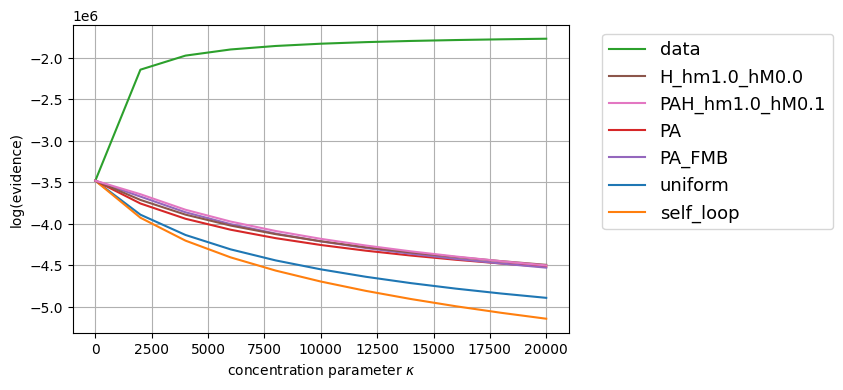

In [18]:
j.plot_evidences(figsize=(8,4), 
                 bboxx=1.3)

### Bayes factor
Compared against the uniform hypothesis

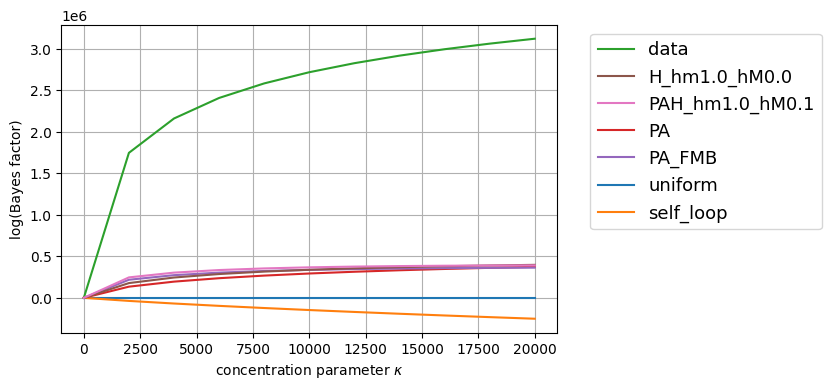

In [19]:
# Plots the bayes factors as the evidence of each hypothesis divided by the evidence of the uniform hypothesis
j.plot_evidences(bayes_factors=True, 
                 figsize=(8,4), 
                 bboxx=1.3,
                 output_dir=PLOTS)

## Task 5. Store all evidence scores

In [20]:
# Stores the dictionary with all evidence scores into disk
j.save_evidences(OUTPUT_DIR)